In [1]:
import pandahouse
import scipy.stats as stats
import seaborn as sns
import numpy as np
import pandas as pd
#
class Getch:
    def __init__(self, query, db='simulator_20220720'):
        self.connection = {
            'host': 'https://clickhouse.lab.karpov.courses',
            'password': 'dpo_python_2020',
            'user': 'student',
            'database': db,
        }
        self.query = query
        self.getchdf

    @property
    def getchdf(self):
        try:
            self.df = pandahouse.read_clickhouse(self.query, connection=self.connection)

        except Exception as err:
            print("\033[31m {}".format(err))
            exit(0)

In [2]:
data = Getch(''' SELECT user_id, exp_group,
                countIf(action, action='like') as likes,
                countIf(action, action='view') as views,
                countIf(action, action='like') / countIf(action, action='view') as ctr
                FROM {db}.feed_actions
                WHERE time >=  toUnixTimestamp('2022-06-13')
                AND time <= toUnixTimestamp('2022-06-19')
                AND (exp_group = 2 or exp_group = 1)
                GROUP BY user_id, exp_group
                Order by user_id''').df

In [3]:
data_1 = data.query('exp_group == 1')
data_2 = data.query('exp_group == 2')

# CTR

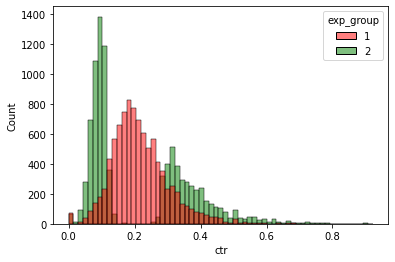

In [4]:
sns.histplot(data=data, x='ctr', hue='exp_group', palette = ['r', 'g']);

In [5]:
stats.ttest_ind(data_1.ctr, data_2.ctr, equal_var = False)

Ttest_indResult(statistic=0.536209812127344, pvalue=0.5918218427419375)

In [6]:
stats.mannwhitneyu(data_1.ctr, data_2.ctr, alternative='two-sided')

MannwhitneyuResult(statistic=49702070.0, pvalue=3.4218087630007513e-67)

Распределения визуально резко отличаются, в контрольной группе походит на нормальное со сдвигом вправо, в экспериментальное группе бимодальное. Т-тест не дает статитсически значимой разницы (и его применение при таком распределении неоправдано), в отличие от Манна-Уитни.

# Smoothed CTR

In [7]:
global_ctr_1 = data_1.likes.sum() / data_1.views.sum()
global_ctr_2 = data_2.likes.sum() / data_2.views.sum()

In [8]:
data['global_ctr'] = data.exp_group.apply(lambda x: global_ctr_1 if x == 1 else global_ctr_2)

In [9]:
data['smoothed_ctr'] = (data.likes + 5 * data.global_ctr) / (5 + data.views)

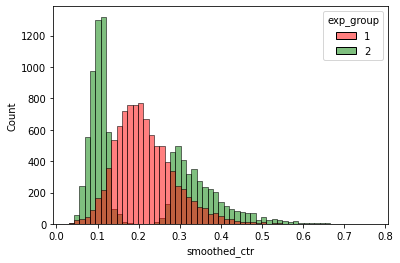

In [10]:
sns.histplot(data=data, x='smoothed_ctr', hue='exp_group', palette = ['r', 'g']);

In [11]:
data_1 = data.query('exp_group == 1')
data_2 = data.query('exp_group == 2')

In [12]:
stats.ttest_ind(data_1.smoothed_ctr, data_2.smoothed_ctr, equal_var=False)

Ttest_indResult(statistic=2.399959074862206, pvalue=0.016409722243995905)

In [13]:
stats.mannwhitneyu(data_1.smoothed_ctr, data_2.smoothed_ctr, alternative='two-sided')

MannwhitneyuResult(statistic=50009116.0, pvalue=1.1696569293279285e-73)

При сглаживании CTR визуально распределения похожи на обычный CTR, однако т-тест начал ловить разницу

# Poisson-Bootstrap

In [14]:
def bootstrap(likes_1, likes_2, views_1, views_2, n_bootstrap):
    weights_1 = stats.poisson(1).rvs((n_bootstrap, len(likes_1))).astype(np.int64)
    weights_2 = stats.poisson(1).rvs((n_bootstrap, len(likes_2))).astype(np.int64)
    global_ctr_1 = (weights_1 * likes_1).sum(axis=1) / (weights_1 * views_1).sum(axis=1)
    global_ctr_2 = (weights_2 * likes_2).sum(axis=1) / (weights_2 * views_2).sum(axis=1)
    return global_ctr_1, global_ctr_2

likes_1 = data_1.likes.to_numpy()
likes_2 = data_2.likes.to_numpy()
views_1 = data_1.views.to_numpy()
views_2 = data_2.views.to_numpy()

global_ctr_1, global_ctr_2 = bootstrap(likes_1, likes_2, views_1, views_2, 1000)

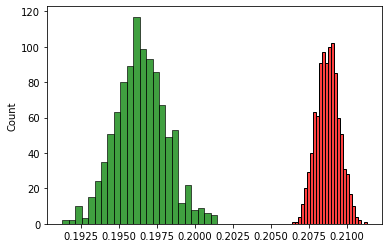

In [15]:
sns.histplot(global_ctr_1, color='r')
sns.histplot(global_ctr_2, color='g');

После бутстрапирования разница между группами очевидна, CTR контрольной группы  выше, распределение уже

# Bucketing

In [16]:
import hashlib

In [17]:
def bucketing(id, salt='bucket', n_groups = 50):
    bucket_id = str(id) + '-' + str(salt)
    bucket_id_digest = hashlib.md5(bucket_id.encode('ascii')).hexdigest()
    bucket_id_f = int(bucket_id_digest, 16)
    return bucket_id_f % n_groups

In [18]:
data['buckets'] = data.user_id.apply(bucketing)

In [19]:
buckets = data.groupby(['exp_group', 'buckets']).sum().reset_index()

In [20]:
buckets['bucket_ctr'] = buckets.likes / buckets.views

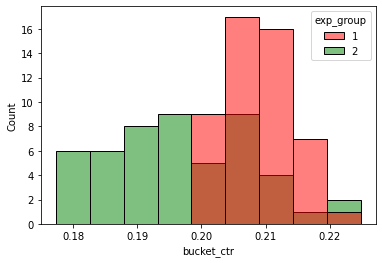

In [21]:
sns.histplot(buckets, hue='exp_group', x='bucket_ctr', palette = ['r', 'g']);

In [22]:
stats.mannwhitneyu(buckets[buckets.exp_group == 1].bucket_ctr, 
                   buckets[buckets.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=2071.0, pvalue=1.5459969290584077e-08)

In [23]:
stats.ttest_ind(buckets[buckets.exp_group == 1].bucket_ctr, 
                   buckets[buckets.exp_group == 2].bucket_ctr,
                   equal_var=False)

Ttest_indResult(statistic=6.750858459345024, pvalue=3.9090316443901246e-09)

При разбивке на 50 бакетов и Т-критерий. и Манн-Уитни дают статистически значимые отличия